# 第三章第四节 数据增强——transforms&albumentations

 1.  几何变换
       - 调整大小: `Resize`可以将图像调整到指定的大小。
       - 随机裁剪: `RandomCrop`和`RandomResizedCrop`可以随机裁剪图像。
       - 中心裁剪: `CenterCrop`从图像的中心裁剪出指定大小。
       - 五裁剪和十裁剪: `FiveCrop`和`TenCrop`分别裁剪出图像的四个角和中心区域。
       - 翻转: `RandomHorizontalFlip`和`RandomVerticalFlip`可以水平或垂直翻转图像。
       - 旋转: `RandomRotation`可以随机旋转图像。
       - 仿射变换: `RandomAffine`可以进行随机的仿射变换。
       - 透视变换: `RandomPerspective`可以进行随机的透视变换。

2. 颜色变换
   - 颜色抖动: `ColorJitter`可以随机改变图像的亮度、对比度、饱和度和色调。
   - 灰度化: `Grayscale`和`RandomGrayscale`可以将图像转换为灰度图。
   - 高斯模糊: `GaussianBlur`可以对图像进行高斯模糊。
   - 颜色反转: `RandomInvert`可以随机反转图像的颜色。
   - 颜色 posterize: `RandomPosterize`可以减少图像中每个颜色通道的位数。
   - 颜色 solarize: `RandomSolarize`可以反转图像中所有高于阈值的像素值。

3. 自动增强
   - 自动增强: `AutoAugment`可以根据数据集自动学习数据增强策略。
   - 随机增强: `RandAugment`可以随机应用一系列数据增强操作。
   - `TrivialAugmentWide`:提供与数据集无关的数据增强。
   - `AugMix`:通过混合多个增强操作进行数据增强。  

PyTorch 不仅可设置对数据的操作，还可以对这些操作进行随机选择、组合，让数据增强更加灵活。

具体有以下4个方法：

* Lambda ：可进行自定义的操作

* RandomChoice ：以一定的概率从中选择一个变换方法执行。

* RandomOrder ：随机打乱一串变换方法。

* RandomApply ：以一定的概率执行这一串变换方法。这与RandomChoice的区别仅在于它将一组变换看成一个选择单位，RandomChoice是一次选一个，RandomApply是一次选一组（list）

In [3]:
from torchvision.transforms import v2

transforms = v2.Compose([
    ####几何变换####
    v2.Resize((256, 256)),
    v2.FiveCrop(size=(100, 100)),   # 将图像或视频裁剪为四个角，然后进行中央裁剪。
    v2.RandomPerspective(distortion_scale=0.6, p=1.0),  # 随机透视转换
    v2.RandomRotation(degrees=(0, 180)),                # 随机旋转
    v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)), # 随机仿射
    v2.RandomHorizontalFlip(), # 随机水平翻转
    v2.RandomVerticalFlip(),   # 随机垂直翻转
    ####颜色变换
    v2.RandomInvert(),  # 随机反转颜色
    v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),  # 高斯模糊变换
    v2.ColorJitter(brightness=.5, hue=.3),    # 颜色抖动
    v2.Grayscale(),    # 将图像转换为灰度图
    v2.RandomPosterize(bits=2), # 减少图像中每个颜色通道的位数
    v2.RandomSolarize(threshold=192.0), # 反转图像中所有高于阈值的像素值
    v2.RandomAdjustSharpness(sharpness_factor=2),  # 随机锐度
    v2.RandomEqualize(),       # 随机均衡
    v2.RandomAutocontrast(),   # 随机自动对比
    ####自动增强####
    v2.AugMix(),   # 混合多个增强操作进行数据增强
    v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),  # 根据给定的自动增强策略自动增强数据
    v2.RandAugment(), # 随机策略增强
    v2.TrivialAugmentWide(),  # AutoAugment 的替代实现，独立于数据集的数据增强

    v2.ToTensor(), # [已废弃] 使用v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]) 代替.
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

G:\Anaconda3\envs\pytorch2.4\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt

def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train) or img_.max() < 1:
        img_ = img_.detach().numpy() * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_

class COVID19Dataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        """
        获取数据集的路径、预处理的方法
        """
        self.root_dir = root_dir
        self.txt_path = txt_path
        self.transform = transform
        self.img_info = []  # [(path, label), ... , ]
        self.label_array = None
        self._get_img_info()

    def __getitem__(self, index):
        """
        输入标量index, 从硬盘中读取数据，并预处理，to Tensor
        :param index:
        :return:
        """
        path_img, label = self.img_info[index]
        img = Image.open(path_img).convert('L')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        if len(self.img_info) == 0:
            raise Exception("\ndata_dir:{} is a empty dir! Please checkout your path to images!".format(
                self.root_dir))  # 代码具有友好的提示功能，便于debug
        return len(self.img_info)

    def _get_img_info(self):
        """
        实现数据集的读取，将硬盘中的数据路径，标签读取进来，存在一个list中
        path, label
        :return:
        """
        # 读取txt，解析txt
        with open(self.txt_path, "r") as f:
            txt_data = f.read().strip()
            txt_data = txt_data.split("\n")

        self.img_info = [(os.path.join(self.root_dir, i.split()[0]), int(i.split()[2]))
                         for i in txt_data]
        
# you can download the datasets from
# https://pan.baidu.com/s/18BsxploWR3pbybFtNsw5fA  code：pyto
root_dir = r"E:\PyTorch-Tutorial-2nd\data\datasets\covid-19-demo"  # path to datasets——covid-19-demo
img_dir = os.path.join(root_dir, "imgs")
path_txt_train = os.path.join(root_dir, "labels", "train.txt")

### Resize

In [5]:
transforms_func = transforms.Compose([
    transforms.Resize((2, 2)),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

torch.Size([2, 1, 2, 2]) tensor([[[[0.4510, 0.4314],
          [0.5373, 0.5294]]],


        [[[0.3804, 0.3882],
          [0.4941, 0.5294]]]])


思考为什么会报错？
提示：
1. 注意resize的size为int时的操作
2. 注意看报错信息，torch.stack....
3. 通常会resize会配CenterCrop进行使用，以此保证图像大小一致

In [6]:
transforms_func = transforms.Compose([
    transforms.Resize(5), 
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

RuntimeError: stack expects each tensor to be equal size, but got [1, 6, 5] at entry 0 and [1, 5, 5] at entry 1

### Normalize

In [8]:
transforms_func = transforms.Compose([
    transforms.Resize((2, 2)),
    # 将PIL对象或nd.array对象转换成tensor，并且对数值缩放到[0, 1]之间，并且对通道进行右移
    # 对PIL对象的通道进行右移，由原来的(H x W x C)变为了(C x H x W) ，接着对数值进行除以255，若是正常的图像像素，那么数值被缩放到了[0, 1]之间。
    transforms.ToTensor(),
    # 对tensor对象进行逐通道的标准化，具体操作为减均值再除以标准差
    # 一般使用imagenet的128万数据R\G\B三通道统计得到的mean和std，mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

torch.Size([2, 1, 2, 2]) tensor([[[[ 0.2549,  0.1569],
          [ 0.6863,  0.6471]]],


        [[[-0.0980, -0.0588],
          [ 0.4706,  0.6471]]]])


### FiveCrop（涨点神器）

观察一下代码错误，可自行复制代码段到pycharm中单步调试，观察何处报错。
提示：由于compose是依次运行的，由于fivecrop返回的img不能被下一个transforms方法接收，因此报错。
代码段回顾：
def __call__(self, img):
    for t in self.transforms:
        img = t(img)
    return img

In [5]:
transforms_func = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.FiveCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape, data)

TypeError: pic should be PIL Image or ndarray. Got <class 'tuple'>

FiveCrop的正确打开方式
代码解释：
1. transforms.Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops]))

    Lambda是可自定义的变换操作，在这里为的是将一个list的图像堆叠为符合后续变换需要的3D-tensor形式。到了compose里，传入lambda的是fivecrop的输出，是一个长度为5的list，然后再lambda里，对这个list进行循环，每一个图像会经过totensor，然后这个list经过torch.stack，就变为了一个4D-tensor。（这里需要大家熟悉compoese的call函数里的那个for循环，各变换是依次进行的。）

2. print(data.shape, data)
dataloader将4D-tensor进行组装，增加batch的维度，得到了一个[2, 5, 1, 224, 224]的张量

3. result = model(data.view(-1, c, h, w))
因为模型的输入只能是4D-tensor，shape为 BCHW，所以需要把数据重新排一下，把crops暂时排到batch维度

In [9]:
class TinnyCNN(nn.Module):
    def __init__(self, cls_num=2):
        super(TinnyCNN, self).__init__()
        self.convolution_layer = nn.Conv2d(1, 1, kernel_size=(3, 3))
        self.fc = nn.Linear(36, cls_num)

    def forward(self, x):
        x = self.convolution_layer(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

model = TinnyCNN(2)

In [10]:
from torchvision.transforms import ToTensor

transforms_func = transforms.Compose([
    transforms.Resize((10,10)),
    transforms.FiveCrop(8),
    # Lambda是可自定义的变换操作，在这里为的是将一个list的图像堆叠为符合后续变换需要的3D-tensor形式。
    # 到了compose里，传入lambda的是fivecrop的输出，是一个长度为5的list，然后再lambda里，对这个list进行循环，每一个图像会经过totensor，然后这个list经过torch.stack，就变为了一个4D-tensor。
    transforms.Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    
    # 模型推理
    bs, ncrops, c, h, w = data.size()
    result = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
    print(result.shape, result)
    result_avg = result.view(bs, ncrops, -1).mean(1) # 平均5个结果，当然根据任务，可以选取最大值、取最小值等操作。
    
    print(result_avg.shape, result_avg)

torch.Size([2, 5, 1, 8, 8])
torch.Size([10, 2]) tensor([[-0.2625,  0.0925],
        [-0.1325,  0.2242],
        [-0.1621, -0.0591],
        [-0.0523,  0.3934],
        [-0.2819,  0.3195],
        [-0.1941,  0.0837],
        [-0.0451, -0.1818],
        [-0.0440,  0.0095],
        [ 0.0133,  0.5271],
        [-0.1576,  0.5455]], grad_fn=<AddmmBackward0>)
torch.Size([2, 2]) tensor([[-0.1783,  0.1941],
        [-0.0855,  0.1968]], grad_fn=<MeanBackward1>)


FiveCrop的使用就到这里，TenCrop不再演示，使用方法完全一致，主要要求大家深刻理解transforms.Compose是如何工作的，理解transforms方法前后的配套关系。

### 其余API学习示范

#### 授人以渔：其余的二十多个不在一一介绍，只需要到官方文档上查看接口，并利用本代码运行，观察效果即可。

torch.Size([2, 1, 224, 224])
(224, 224)


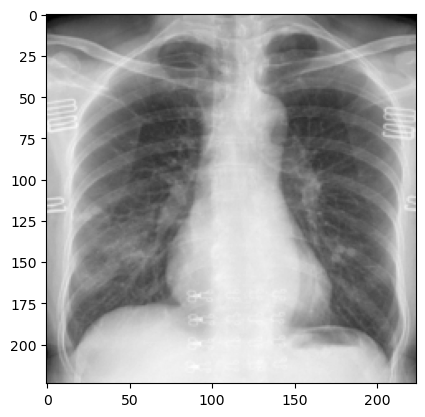

In [11]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    img_tensor = data[0, ...]     # C H W
    img = transform_invert(img_tensor, transforms_func)
    print(img.size)
    plt.imshow(img, cmap="gray")
    plt.show()

#### RandomVerticalFlip

torch.Size([2, 1, 224, 224])
(224, 224)


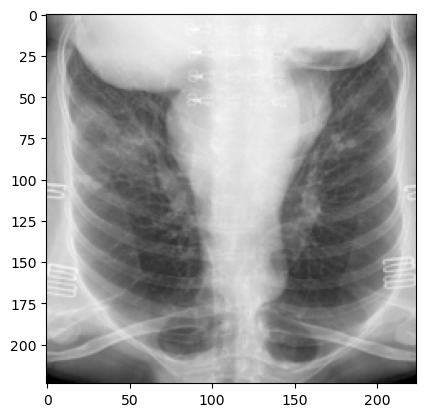

In [12]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=1),  # 为了效果展示，概率设置为1， 通常设置为0.5
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    img_tensor = data[0, ...]     # C H W
    img = transform_invert(img_tensor, transforms_func)
    print(img.size)
    plt.imshow(img, cmap="gray")
    plt.show()

#### transforms.CenterCrop

torch.Size([2, 1, 128, 128])
(128, 128)


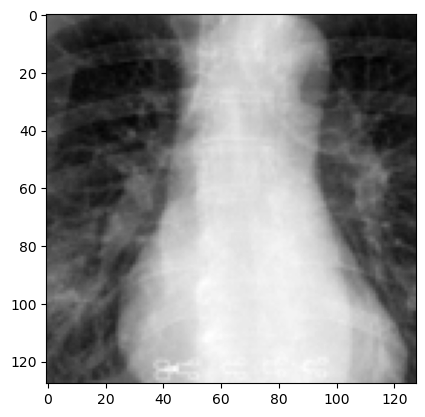

In [13]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data.shape)
    img_tensor = data[0, ...]     # C H W
    img = transform_invert(img_tensor, transforms_func)
    print(img.size)
    plt.imshow(img, cmap="gray")
    plt.show()

### 不在一一展示，可结合官方文档自行学习
* ColorJitter
* GaussianBlur
* RandomPerspective
* RandomRotation
* RandomAffine
* RandomCrop
* RandomResizedCrop
* RandomInvert
* RandomPosterize
* RandomSolarize
* RandomAdjustSharpness
* RandomAutocontrast
* RandomEqualize
* TrivialAugmentWide

### RandomChoice

可以看到变换后的图片，要么填充10个像素，要么垂直翻转，没有即垂直翻转，又填充10个像素的。
这就是randomchoice的作用，从一系列中选择1个。

torch.Size([1, 1, 244, 244])
(244, 244)


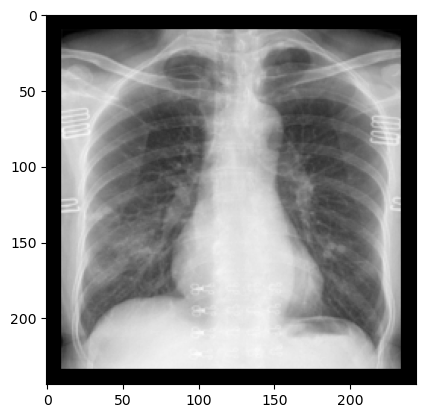

torch.Size([1, 1, 244, 244])
(244, 244)


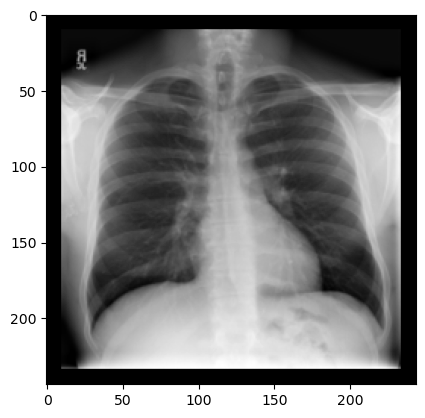

torch.Size([1, 1, 224, 224])
(224, 224)


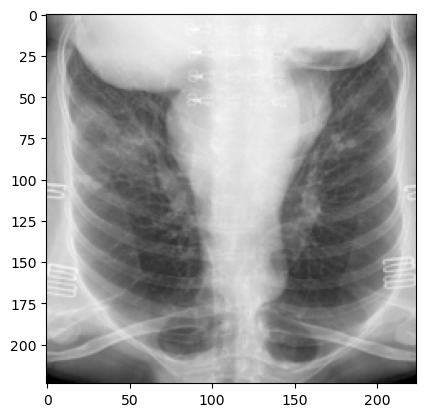

torch.Size([1, 1, 224, 224])
(224, 224)


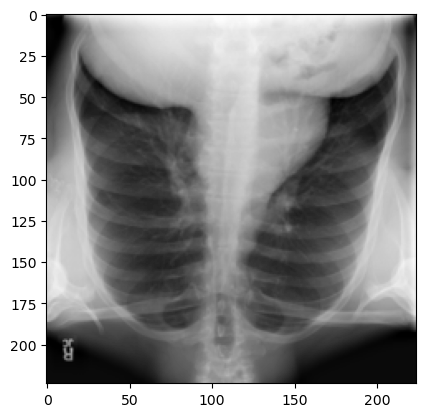

torch.Size([1, 1, 224, 224])
(224, 224)


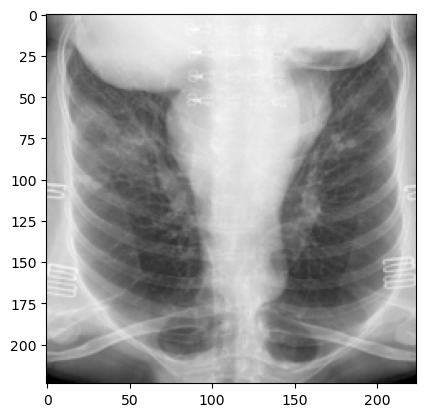

torch.Size([1, 1, 224, 224])
(224, 224)


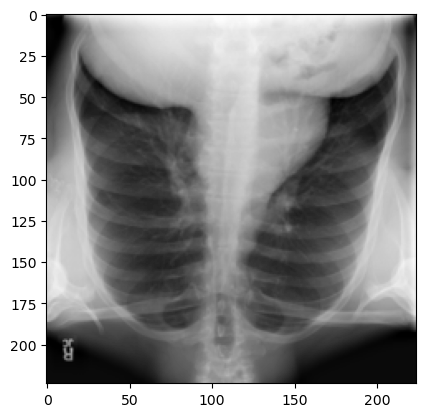

In [14]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomChoice([transforms.Pad(10), transforms.RandomVerticalFlip(p=1)]),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### RandomOrder

随机排序指的是这一系列变换的顺序会随机打乱。  
通过以下代码可以看到如果是先填充再反转，则填充的黑色像素在图像的底部。  
如果是先反转，再填充，则填充的黑色像素区域在图像的顶部。

torch.Size([1, 1, 324, 224])
(224, 324)


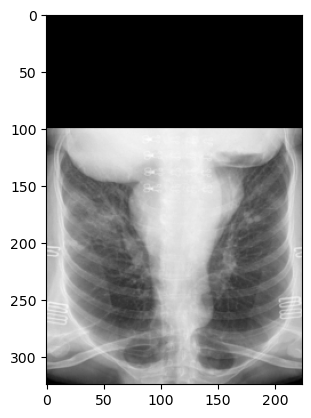

torch.Size([1, 1, 324, 224])
(224, 324)


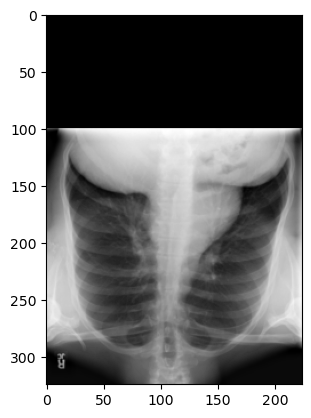

torch.Size([1, 1, 324, 224])
(224, 324)


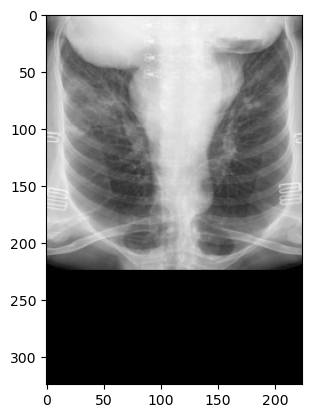

torch.Size([1, 1, 324, 224])
(224, 324)


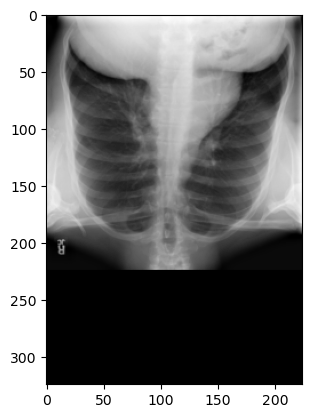

torch.Size([1, 1, 324, 224])
(224, 324)


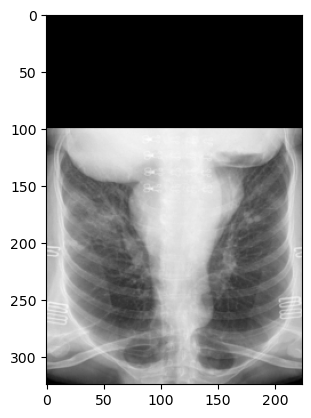

torch.Size([1, 1, 324, 224])
(224, 324)


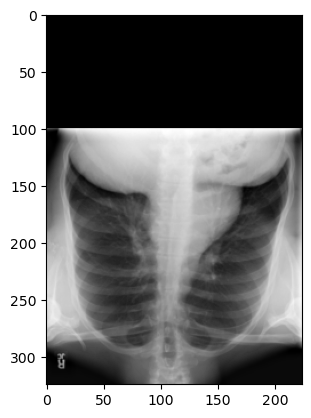

In [15]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomOrder([transforms.Pad((0, 100, 0, 0)), transforms.RandomVerticalFlip(p=1)]),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### RandomApply

randomapply与RandomChoice的区别仅在于它将一组变换看成一个选择单位，RandomChoice是一次选一个，RandomApply是一次选一组（list）.  
可以看到下图中，要么执行缩放 + (填充、反转)，要么只执行缩放。这里的(填充、反转)就是一组变换。

torch.Size([1, 1, 324, 224])
(224, 324)


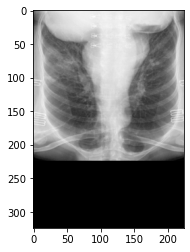

torch.Size([1, 1, 224, 224])
(224, 224)


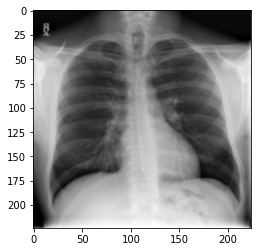

torch.Size([1, 1, 324, 224])
(224, 324)


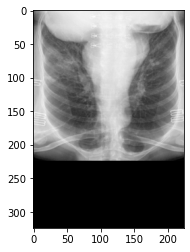

torch.Size([1, 1, 224, 224])
(224, 224)


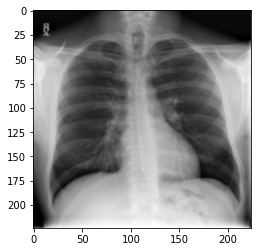

torch.Size([1, 1, 224, 224])
(224, 224)


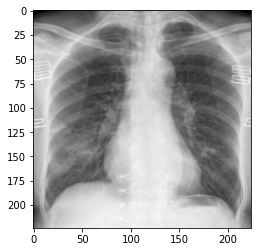

torch.Size([1, 1, 324, 224])
(224, 324)


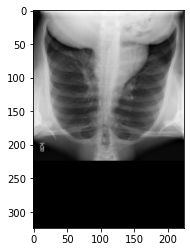

torch.Size([1, 1, 224, 224])
(224, 224)


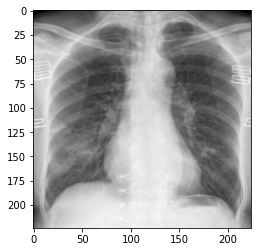

torch.Size([1, 1, 224, 224])
(224, 224)


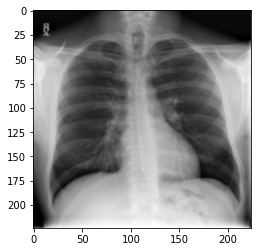

torch.Size([1, 1, 224, 224])
(224, 224)


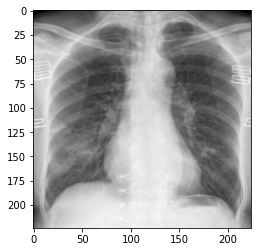

torch.Size([1, 1, 324, 224])
(224, 324)


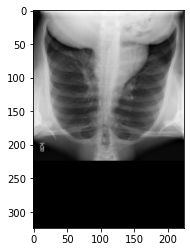

In [19]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.Pad((0, 100, 0, 0)), transforms.RandomVerticalFlip(p=1)], p=0.5),
    transforms.ToTensor()
])
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(5):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### AutoAugmentPolicy

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


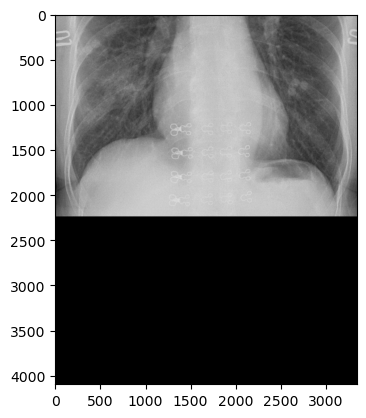

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


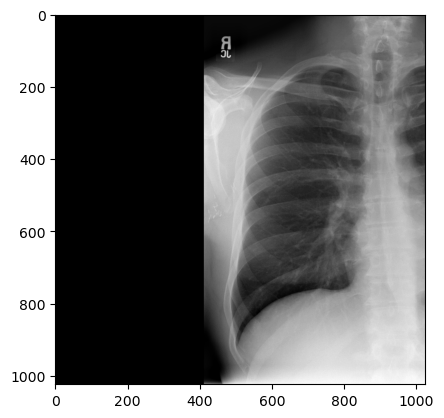

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


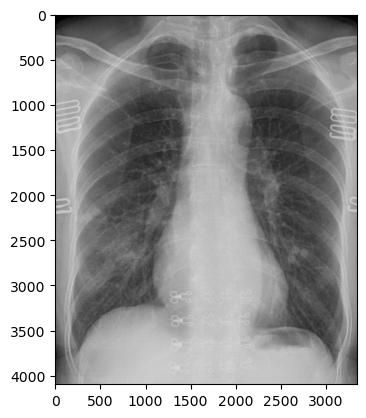

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


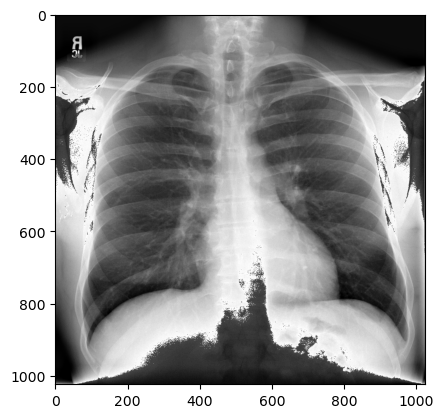

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


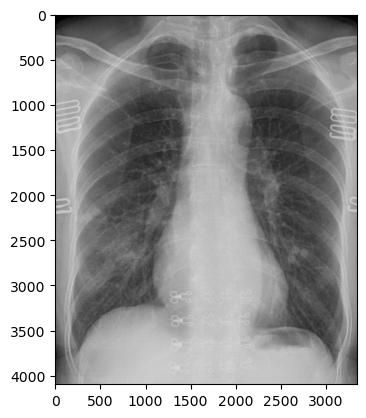

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


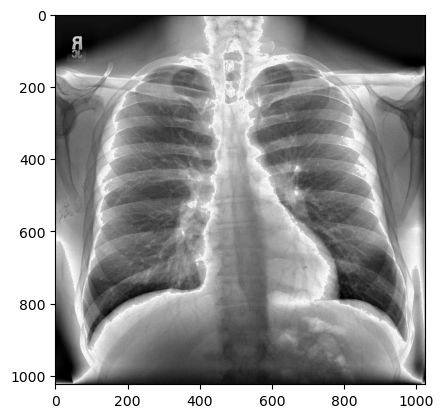

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


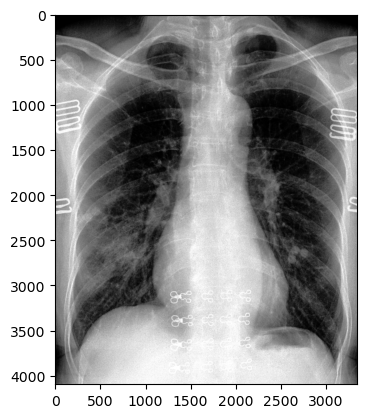

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


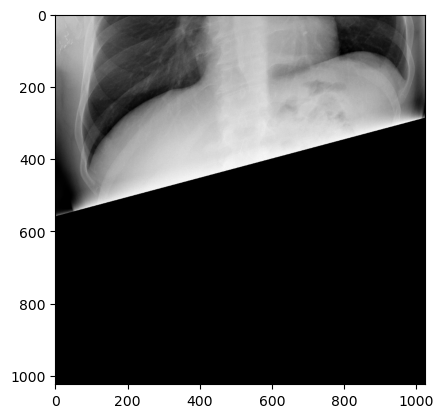

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


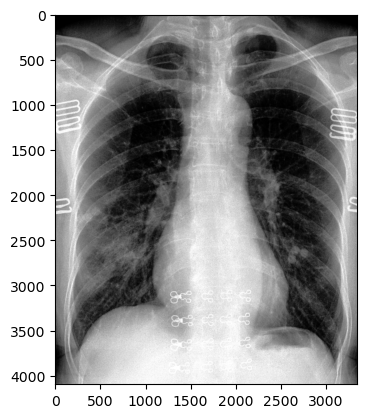

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


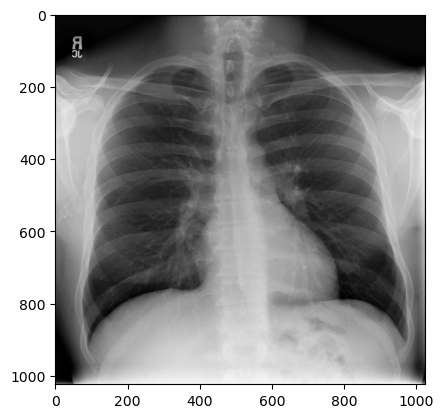

In [16]:
policy = transforms.AutoAugmentPolicy.CIFAR10
# policy = transforms.AutoAugmentPolicy.IMAGENET  
# policy = transforms.AutoAugmentPolicy.SVHN

transforms_func = transforms.Compose([
    transforms.AutoAugment(policy),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
# transforms_func = transforms.AutoAugment(policy)
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(5):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### RandAugment

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


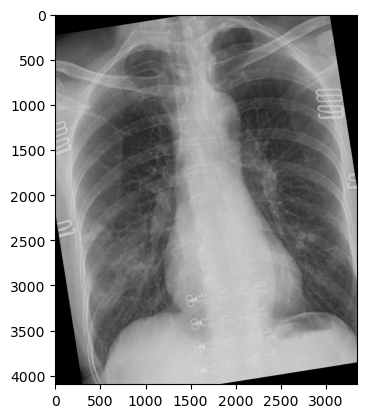

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


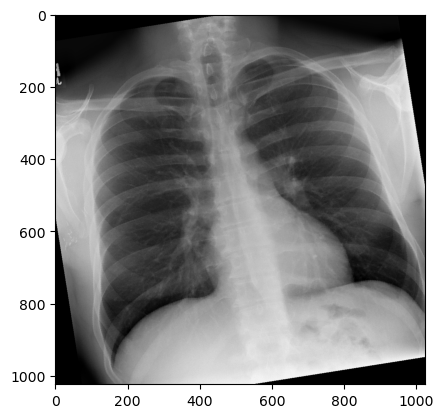

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


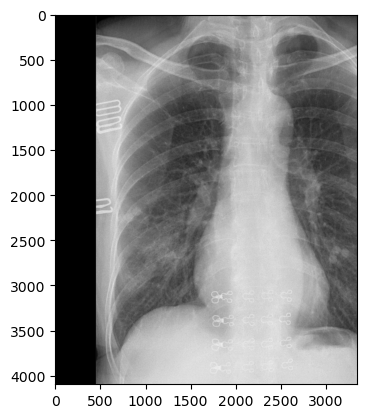

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


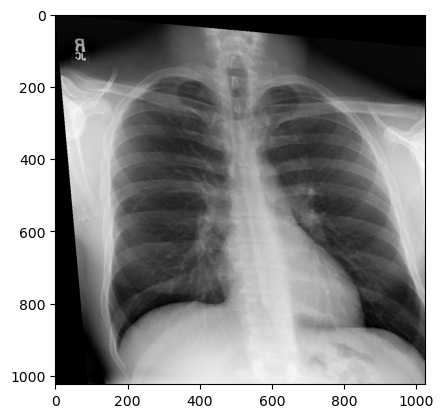

torch.Size([1, 1, 4095, 3342])
(3342, 4095)


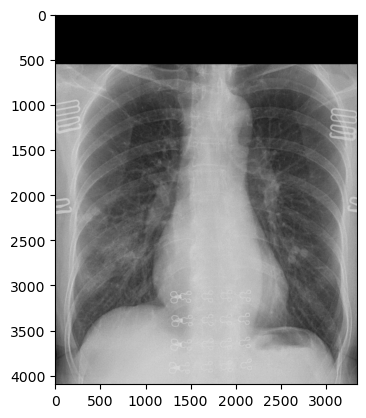

torch.Size([1, 1, 1024, 1024])
(1024, 1024)


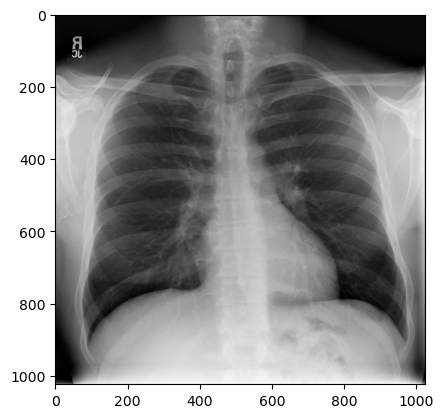

In [17]:
transforms_func = transforms.Compose([
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
# transforms_func = transforms.AutoAugment(policy)
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()

### TrivialAugmentWide

torch.Size([1, 1, 224, 224])
(224, 224)


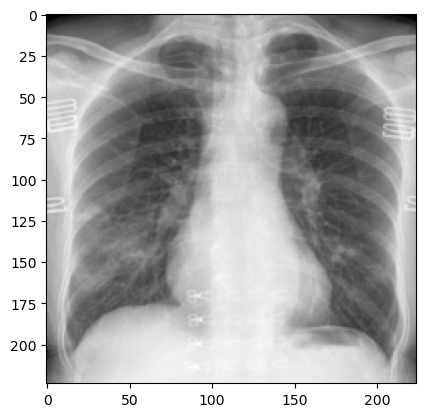

torch.Size([1, 1, 224, 224])
(224, 224)


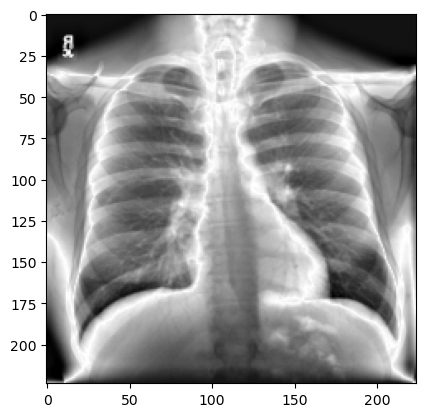

torch.Size([1, 1, 224, 224])
(224, 224)


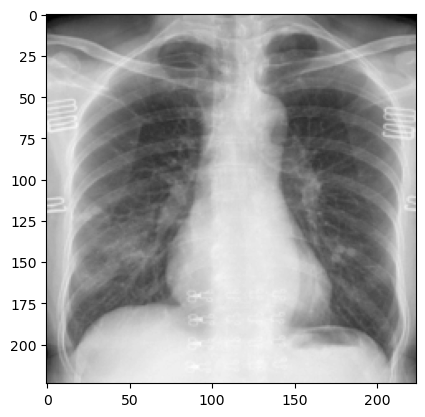

torch.Size([1, 1, 224, 224])
(224, 224)


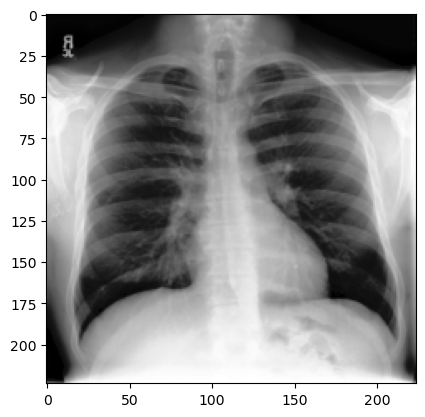

torch.Size([1, 1, 224, 224])
(224, 224)


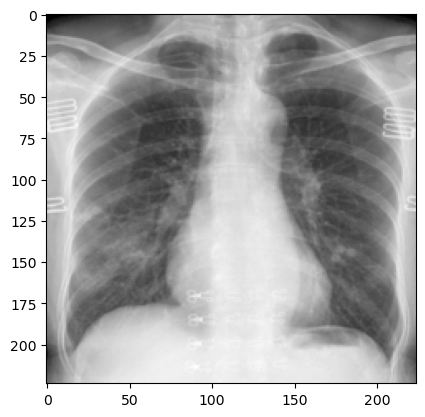

torch.Size([1, 1, 224, 224])
(224, 224)


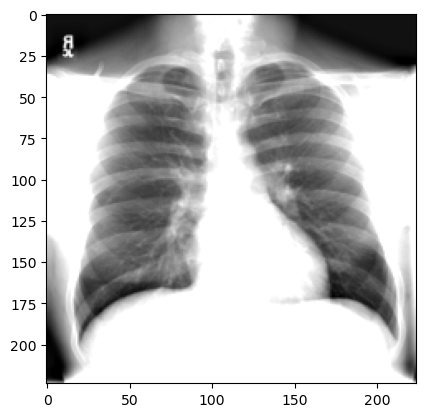

In [18]:
transforms_func = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize([0.4], [0.2])  # 由于本dataset是灰度图，仅1个通道，就不在展示3通道的使用。
])
# transforms_func = transforms.AutoAugment(policy)
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=transforms_func)
train_loader = DataLoader(dataset=train_data, batch_size=1)
for epoch in range(3):
    for data, labels in train_loader:
        print(data.shape)
        img_tensor = data[0, ...]     # C H W
        img = transform_invert(img_tensor, transforms_func)
        print(img.size)
        plt.imshow(img, cmap="gray")
        plt.show()